# Image Segmentation with FCN-ResNet50

This is a simple tutorial to illustrate how to compose a FCN network with a choice of `backbone`. We will be performing inference using a pretrained model
to check the quality of ported weights. This tutorial is based on `torchvision's` tutorial [here](https://pytorch.org/hub/pytorch_vision_fcn_resnet101/).

An important bit to focus on is the initialisation of the model which is different from `torchvision`. 

---

### Installing Dependencies

In [5]:
!pip install eqxvision jaxlib --quiet

### Required Imports

In [6]:
import urllib

import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import eqxvision as eqv
from eqxvision.utils import SEGMENTATION_URLS


%matplotlib inline
from torchvision import transforms

### Data Preparation

In [7]:
# Download an example image from the pytorch website
url, filename = (
    "https://github.com/pytorch/hub/raw/master/images/deeplab1.png",
    "deeplab1.png",
)
try:
    urllib.URLopener().retrieve(url, filename)
except Exception:
    urllib.request.urlretrieve(url, filename)

In [8]:
# sample execution (requires torchvision)
input_image = Image.open(filename)
input_image = input_image.convert("RGB")
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

input_tensor = preprocess(input_image)
img = jnp.asarray(input_tensor.unsqueeze(0).numpy())

### Initialising the Model

To recall, FCN composes of a `main` and an `auxiliary` intermediate layer from the `backbone` neural network. The feature maps from these are forwarded to a classification unit for dense prediction.

To initialise `FCN`, we need to know
1. `backbone`: which is going to act as a feature extractor
2. `intermediate_layers`: The layers in the backbone from where we need the activations
3. `classifier_in_channels`: This is equivalent to the number of channels in the `main` intermediate layer 
3. `aux_in_channels`: If using an auxiliary layer for additional loss, set the number of output channels here    

Additional parameters are described in the documentation [here](https://eqxvision.readthedocs.io/en/latest/api/models/segmentation/fcn/#eqxvision.models.fcn)

In [9]:
model = eqv.models.fcn(
    backbone=eqv.models.resnet50(replace_stride_with_dilation=[False, True, True]),
    intermediate_layers=lambda x: [x.layer3, x.layer4],
    aux_in_channels=1024,
    torch_weights=SEGMENTATION_URLS["fcn_resnet50"],
)
key = jrandom.split(jrandom.PRNGKey(0), 1)

/home/AS3895/miniconda3/envs/eqxvision/lib/python3.8/site-packages/equinox/experimental/stateful.py:217: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(x)
/home/AS3895/miniconda3/envs/eqxvision/lib/python3.8/site-packages/equinox/experimental/stateful.py:218: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  x = jax.tree_unflatten(treedef, leaves)


### Inference

The network returns two outputs corresponding to `auxiliary` and `main` layers. For inference, we are only interested in the `main` output.

Since the predictions are in the shape `(num_classes, height, width)` we select the predicted category per pixel location.

In [10]:
aux_output, output = jax.vmap(model, axis_name="batch")(img, key=key)
output_predictions = jnp.argmax(output[0], axis=0)

### Visualisation

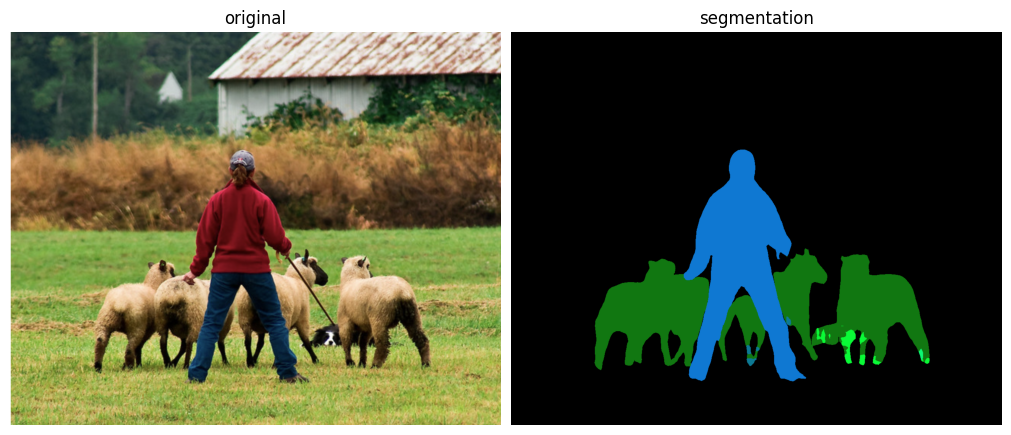

In [11]:
# create a color pallette, selecting a color for each class
palette = jnp.array([2**25 - 1, 2**15 - 1, 2**21 - 1])
colors = jnp.array([i for i in range(21)])[:, None] * palette
colors = np.asarray(colors % 255).astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(np.asarray(output_predictions).astype(np.uint8)).resize(
    input_image.size
)
r.putpalette(colors)

axs = plt.figure(constrained_layout=True, figsize=(10, 18)).subplots(
    1, 2, sharex=True, sharey=True
)

axs[0].set(title="original")
axs[1].set(title="segmentation")
axs[0].imshow(input_image)
axs[1].imshow(r)
axs[0].axis("off")
axs[1].axis("off")
plt.show()

*That's all Folks*